<a id="case"></a> 

## **3 Walmart Sales Forecast**

**Dicionário de Dados**

* Store - número da loja.
* Date - semana da apuração das vendas.
* Weekly_Sales - quantidade de vendas de uma determinada loja.
* Holiday_Flag - 1 se for feriado; 0 caso contrário.
* Temperature - Temperatura na semana de apuração na região da loja
* Fuel_Price - Preço do combustível na região da loja, dados monetários em dólar.
* CPI – Consumer Price Index, índice de inflação ao consumidor na região da loja.
* Unemployment - Taxa de desemprego na região da loja.

**OBJETIVO DA MODELAGEM:** prever as vendas semanais do Walmart, dado o conjunto de dados disponível.

A ideia do time de negócio é utilizar o modelo para planejar ações como estoque e prospectar demanda. Além disso, objetiva-se compreender melhor a inserção e perfil da empresa e suas filiais.

# Importando as bibliotecas

In [1]:
# imports
# manipulação de dados
import pandas as pd
import numpy as np
from math import sqrt

# visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# configuração de warnings
import warnings
warnings.filterwarnings('ignore')

# biblioteca pra exportar o modelo de ML
import joblib

# Abrindo a base de dados

In [2]:
# leitura da base
df = pd.read_csv('Walmart.csv')

# inspeção da base
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# Explory Data Analysis (EDA)

### Visualizando os tipos dos dados

In [3]:
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

### Convertendo a coluna 'Date' para o tipo datetime

In [4]:
df['Date'] = pd.to_datetime(df.Date, format='%d-%m-%Y')
df.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

### Ordenando a base de dados pelas colunas de Data e Vendas

In [5]:
df = (df.sort_values(by=['Date', 'Weekly_Sales'], ascending=True).reset_index(drop=True))
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,33,2010-02-05,274593.43,0,58.40,2.962,126.442065,10.115
1,44,2010-02-05,281090.95,0,31.53,2.666,126.442065,8.119
2,5,2010-02-05,317173.10,0,39.70,2.572,211.653972,6.566
3,38,2010-02-05,358496.14,0,49.47,2.962,126.442065,13.975
4,3,2010-02-05,461622.22,0,45.71,2.572,214.424881,7.368


### Verificando se há valores nulos

In [6]:
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

**Conclusão: Não há valores nulos**

### Verificando se há linhas duplicadas

In [7]:
df.duplicated().sum()

0

**Conclusão: Não há linhas duplicadas**

### Verificando a quantidade de valores únicos em cada coluna

In [8]:
df.nunique().sort_values()

Holiday_Flag       2
Store             45
Date             143
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

**Conclusões:**
1. Holiday_Flag de fato é uma dummy
2. Temos 45 lojas

### Sumário estatístico

In [9]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


**Conclusão: Não identificamos nenhuma variável inconsistente (venda negativa, por exemplo)**

### Copiando o data frame para não perdermos a base original

In [10]:
df_copia = df.copy()
df_copia.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,33,2010-02-05,274593.43,0,58.40,2.962,126.442065,10.115
1,44,2010-02-05,281090.95,0,31.53,2.666,126.442065,8.119
2,5,2010-02-05,317173.10,0,39.70,2.572,211.653972,6.566
3,38,2010-02-05,358496.14,0,49.47,2.962,126.442065,13.975
4,3,2010-02-05,461622.22,0,45.71,2.572,214.424881,7.368


### Explorando funções de datas a fim de aprendizagem

In [11]:
# cria colunas a partir da data
df_copia['month'] = df_copia.Date.dt.month # Retorna o número do mês
df_copia['year'] = df_copia.Date.dt.year # Retorna o número do ano
df_copia['dayofweek'] = df_copia.Date.dt.dayofweek # Retorna o número da semana
df_copia['day_name'] = df_copia.Date.dt.day_name() # Retorna o nome da semana
df_copia['is_month_start'] = df_copia.Date.dt.is_month_start.map({True:1, False:0}) # Mostra se a data é o primeiro dia do mês
df_copia['is_month_end'] = df_copia.Date.dt.is_month_end.map({True:1, False:0}) # Indica se é o último dia do mês
df_copia['days_in_month'] = df_copia.Date.dt.days_in_month # Retorna quantos dias aquele mês possui
df_copia['is_quarter_start'] = df_copia.Date.dt.is_quarter_start.map({True:1, False:0}) # Indica se a data é o primeiro dia do semestre
df_copia['is_quarter_end'] = df_copia.Date.dt.is_quarter_end.map({True:1, False:0}) # Indica se a data é o último dia de um semestre
df_copia.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,year,dayofweek,day_name,is_month_start,is_month_end,days_in_month,is_quarter_start,is_quarter_end
0,33,2010-02-05,274593.43,0,58.40,2.962,126.442065,10.115,2,2010,4,Friday,0,0,28,0,0
1,44,2010-02-05,281090.95,0,31.53,2.666,126.442065,8.119,2,2010,4,Friday,0,0,28,0,0
2,5,2010-02-05,317173.10,0,39.70,2.572,211.653972,6.566,2,2010,4,Friday,0,0,28,0,0
3,38,2010-02-05,358496.14,0,49.47,2.962,126.442065,13.975,2,2010,4,Friday,0,0,28,0,0
4,3,2010-02-05,461622.22,0,45.71,2.572,214.424881,7.368,2,2010,4,Friday,0,0,28,0,0


### Verificando quais dias da semana foram realizadas as apurações

In [12]:
pd.DataFrame(df_copia['day_name'].value_counts())

,day_name
Friday,6435


**Conclusões: Todas as apurações foram realizadas as sextas-ferias**

## Daqui em diante vamos focar em entender o comportamento das variáveis

### Criando um data frame mensal (aplicando-se média)

In [13]:
month_data = df.set_index('Date')\
    .resample('m')[['Weekly_Sales', 'CPI', 'Unemployment']]\
    .mean()

In [14]:
month_data.head()

,Weekly_Sales,CPI,Unemployment
Date,,,
2010-02-28,1.057405e+06,167.834459,8.619311
2010-03-31,1.010666e+06,167.930846,8.619311
2010-04-30,1.028499e+06,167.678437,8.497711
2010-05-31,1.037283e+06,167.641758,8.497711
2010-06-30,1.068034e+06,168.004688,8.497711


### Criando uma função para visualizar as variáveis ao longo do tempo

In [15]:
# cria figura e eixo
def plot_line_month_data(feature, title, ylabel):
    fig, ax = plt.subplots(figsize=(10, 4))
    # cálculo das vendas médias mensais
    month_data[feature].plot(ax=ax, color='black', linewidth=2)
    # labels
    # título
    plt.title(title, fontweight='bold', pad=15)
    # rótulo do eixo x
    plt.xlabel('')
    # rótulo do eixo y
    plt.ylabel(ylabel)
    # oculta spines
    ax.spines['top'].set_visible(False) # Retirando a moldura superior
    ax.spines['right'].set_visible(False) # Retirando a moldura da direita
    plt.show()

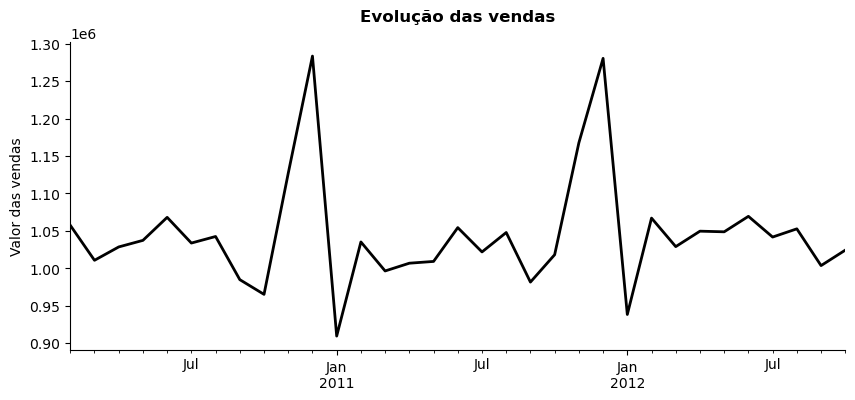

In [16]:
plot_line_month_data(
    'Weekly_Sales', 
    'Evolução das vendas', 
    'Valor das vendas'
)

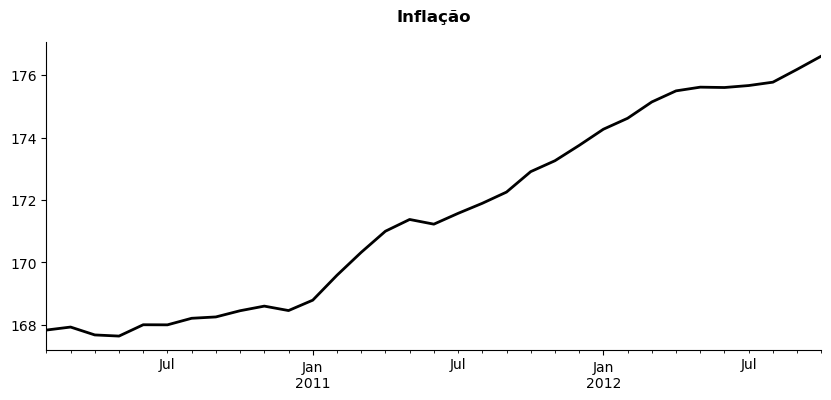

In [17]:
plot_line_month_data(
    'CPI', 
    'Inflação', 
    ''
)

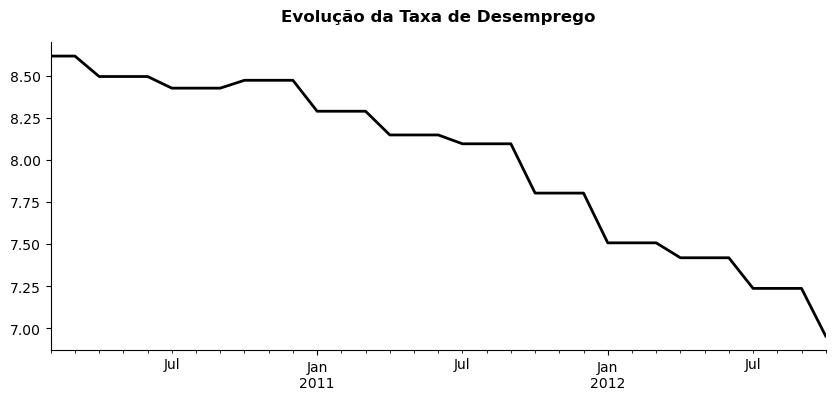

In [18]:
plot_line_month_data(
    'Unemployment', 
    'Evolução da Taxa de Desemprego', 
    ''
)

### Criando uma função para comparar uma variável versus outra ao longo do tempo

In [19]:
def plot_two_axes(variavel_eixo_1, variavel_eixo_2, title):
    # cria figura e eixo
    fig, ax1 = plt.subplots(figsize=(8, 5))
    # título
    fig.suptitle(title, fontweight='bold')
    # eixo 1
    month_data[variavel_eixo_1].plot(ax=ax1, color='black', linewidth=2)
    ax1.set_ylabel(variavel_eixo_1)

    # cria segundo eixo
    ax2 = ax1.twinx()
    month_data[variavel_eixo_2].plot(ax=ax2, color='lightgray', linewidth=2)
    ax2.set_ylabel(variavel_eixo_2)
    
    # adiciona legenda
    fig.legend()
    plt.show()

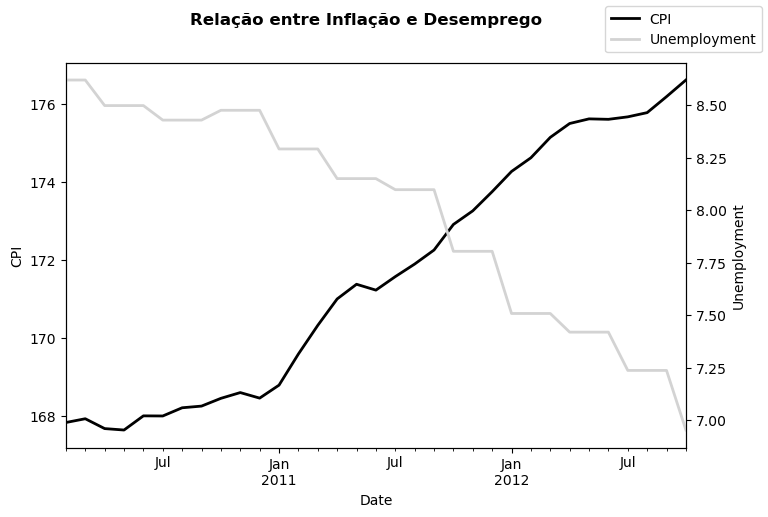

In [20]:
plot_two_axes(
    'CPI', 
    'Unemployment', 
    'Relação entre Inflação e Desemprego'
)

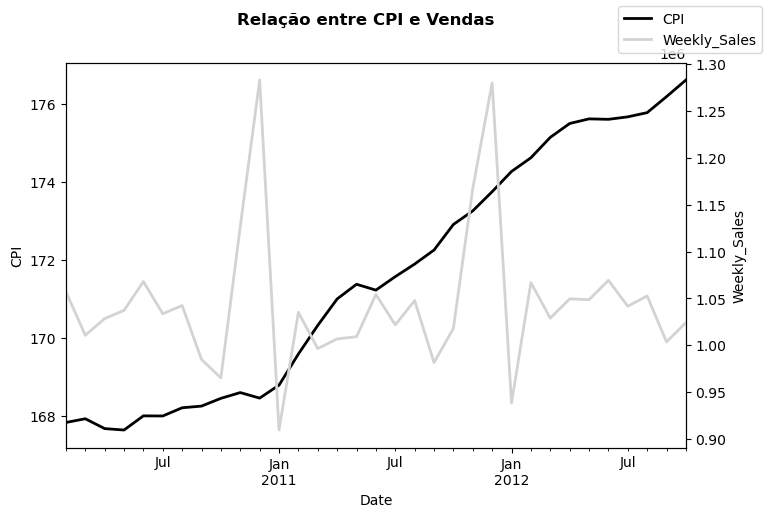

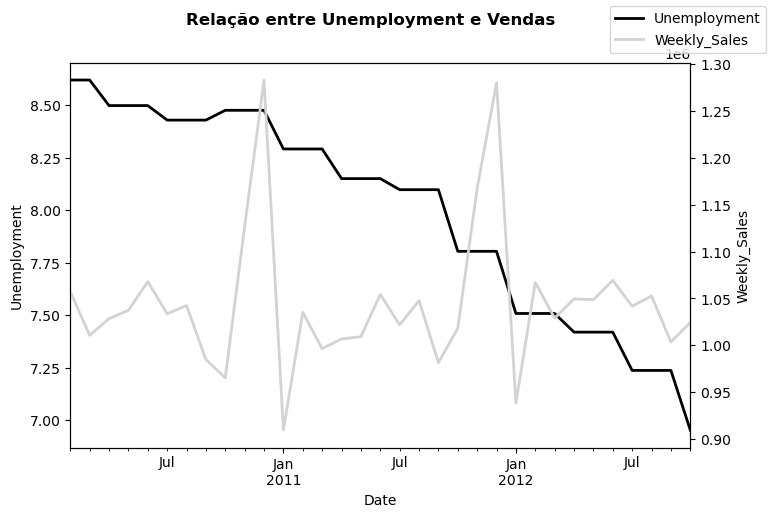

In [21]:
for feature in ['CPI', 'Unemployment']:
    plot_two_axes(
        feature,
        'Weekly_Sales',
        f'Relação entre {feature} e Vendas'
    )

### Verificando se em fias de feriados a média das vendas é maior

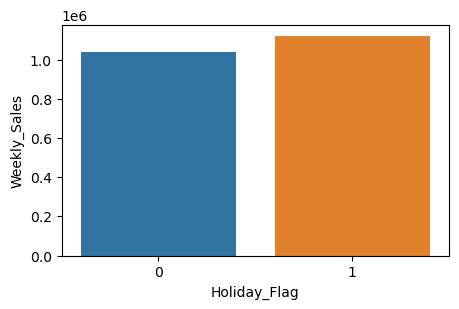

In [22]:
media_feriado = df.groupby('Holiday_Flag').mean()[['Weekly_Sales']]
plt.figure(figsize = (5, 3))
sns.barplot(x = media_feriado.index, y = media_feriado['Weekly_Sales'], data = media_feriado)
plt.show()

**Conclusão: Não há uma diferença significante entre as vendas**

### Verificando se em dias mais quentes ou mais frio há uma média maior de vendas

In [23]:
# Agrupando as temperaturas em faixas de 10 em 10
df_copia['Faixa_temperatura'] = pd.cut(x=df_copia['Temperature'], bins=range(0,111,10))

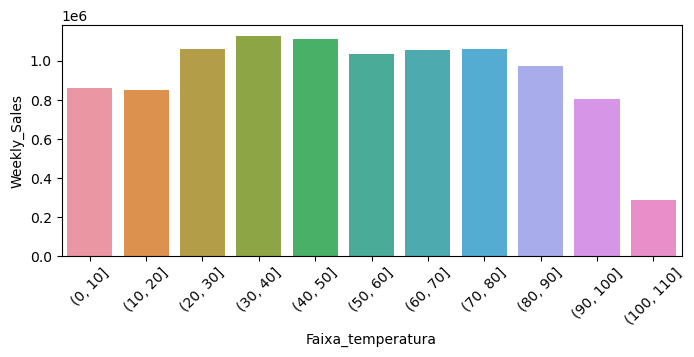

In [24]:
media_temperatura = df_copia.groupby('Faixa_temperatura').mean()[['Weekly_Sales']]
plt.figure(figsize = (8, 3))
sns.barplot(x = media_temperatura.index,
            y = media_temperatura['Weekly_Sales'],
            data = media_temperatura)
plt.xticks(rotation=45)
plt.show()

**Conclusão: Em dias muitos quentes as vendas são menores**

### Análise estatística

In [25]:
# lista com colunas numéricas
num_cols = df.select_dtypes(include='number').columns.tolist()

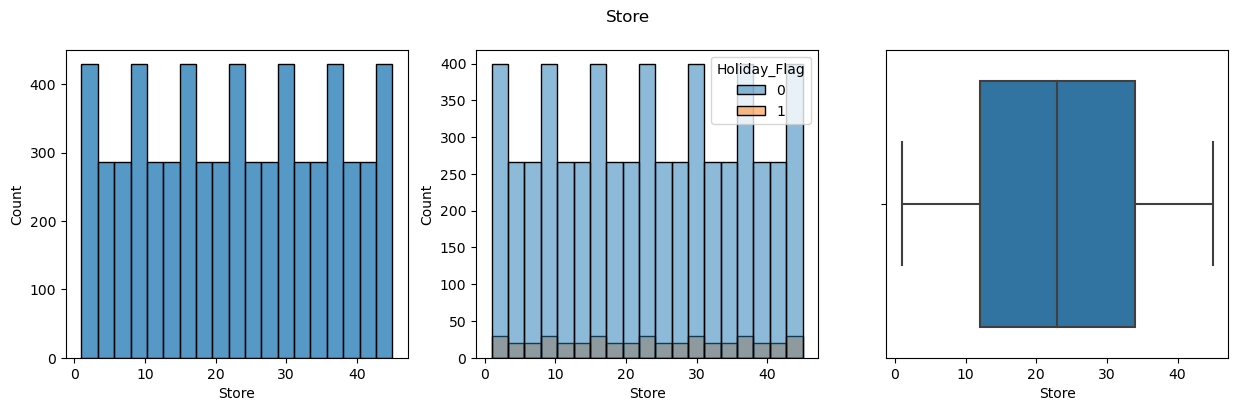

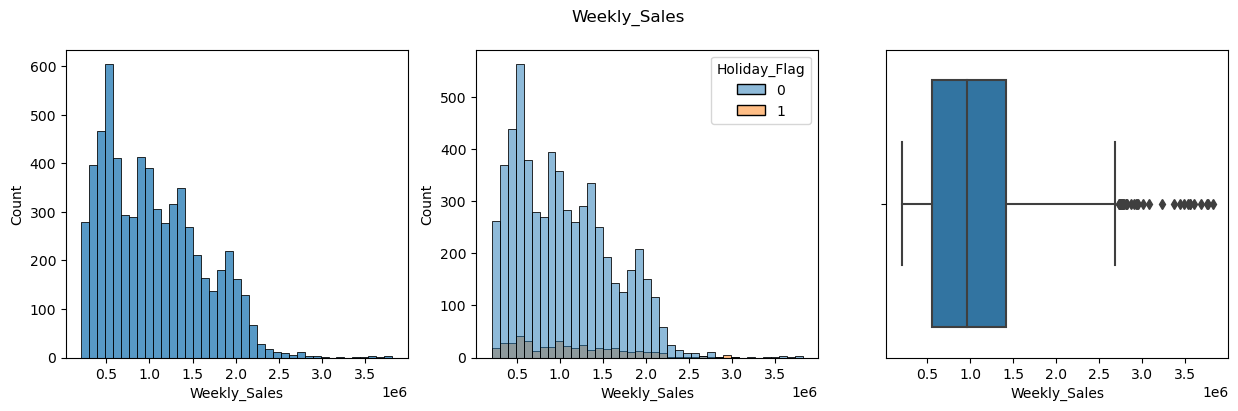

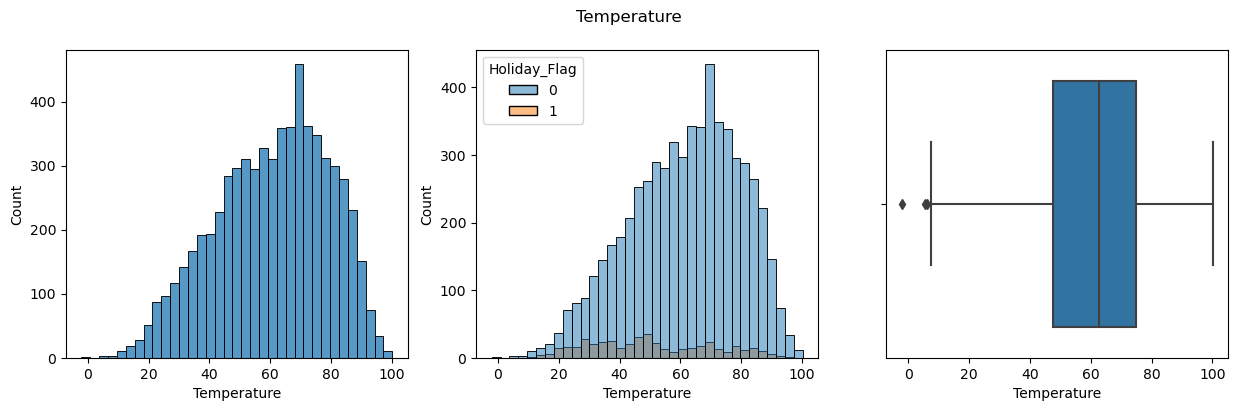

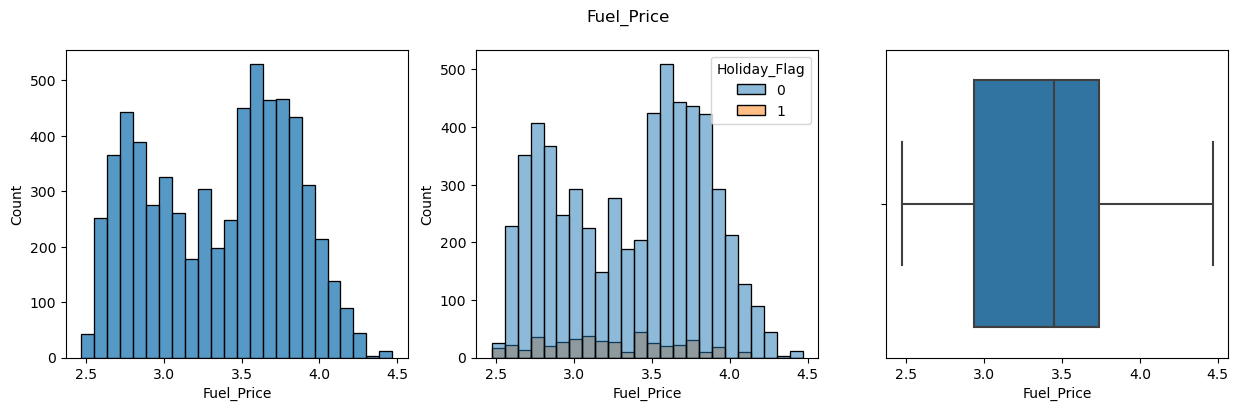

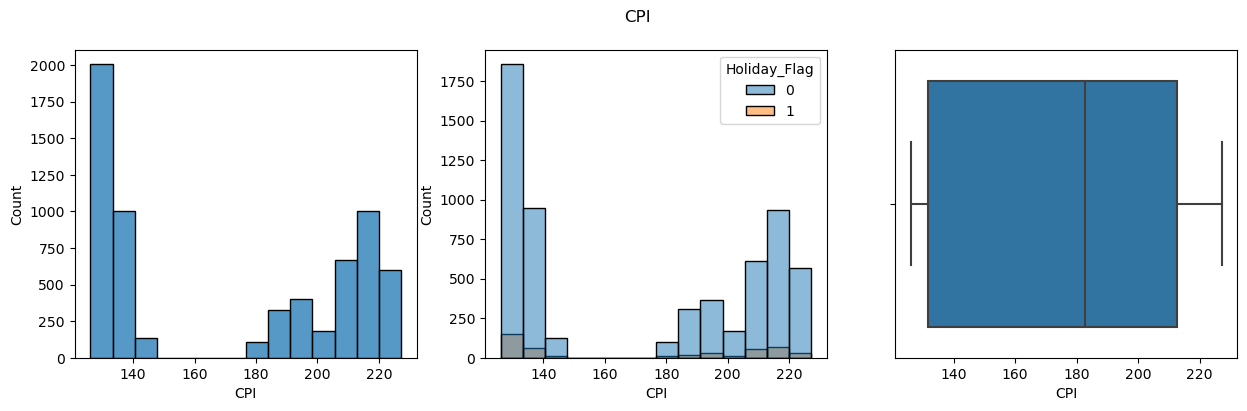

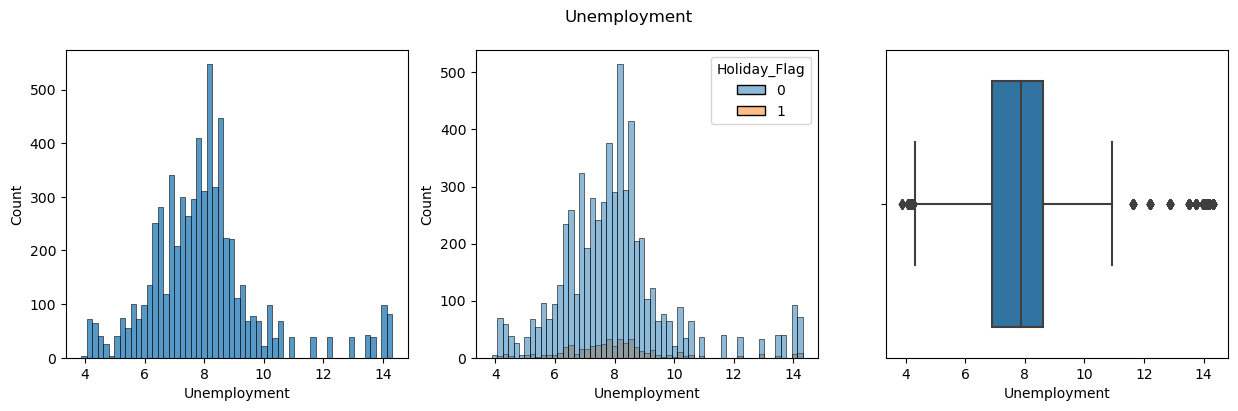

In [26]:
for feature in num_cols:
    #  se a variável for igual a 'Holiday_Flag' pula o laço
    if feature == 'Holiday_Flag':
        continue
    # cria figura e eixo
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(feature)
    # histograma
    sns.histplot(df[feature], ax=ax[0])
    sns.histplot(x=feature, ax=ax[1], data=df, hue='Holiday_Flag')
    # boxplot
    sns.boxplot(df[feature], orient='h', ax=ax[2])
    plt.show()

### Separando as variáveis independentes da dependente

In [27]:
X = df.drop(['Weekly_Sales'], axis = 1).set_index('Date')

X_linearizado = np.log(X)

y = df['Weekly_Sales']

### Criando função para visualizar a relação entre as variáveis independentes e dependente

In [28]:
def plot_scatter(eixo_x, eixo_y, data):
    # ajusta tamanho da figura
    plt.figure(figsize=(8, 5))
    # scatter plot
    plt.scatter(eixo_x, eixo_y, data=data)
    # labels
    plt.title(f'Relação entre Weekly_Sales e {eixo_x}', fontweight='bold')
    plt.xlabel(eixo_x)
    plt.ylabel('Weekly_Sales')
    # configura gridlines
    plt.grid(alpha=0.3)
    plt.show()

### Visualizando a relação das variáveis independentes com as variáveis dependente (sem linearizar os dados)

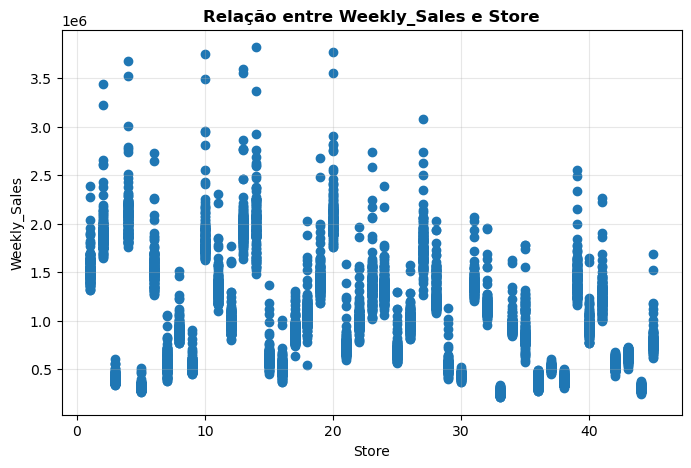

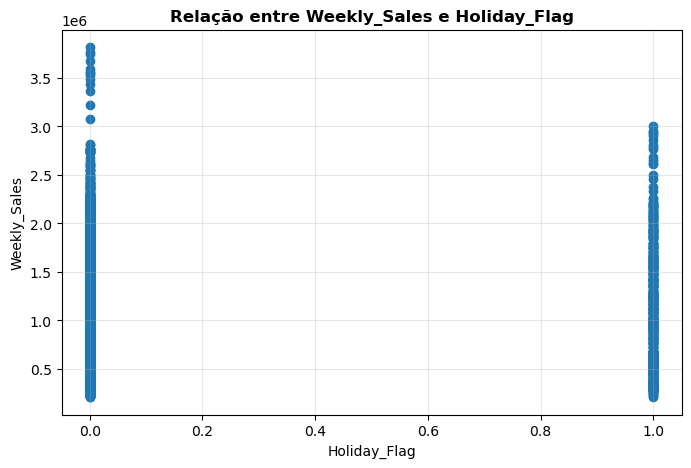

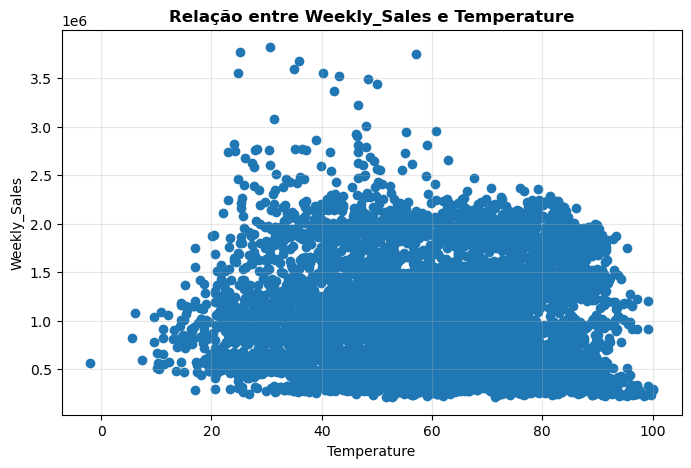

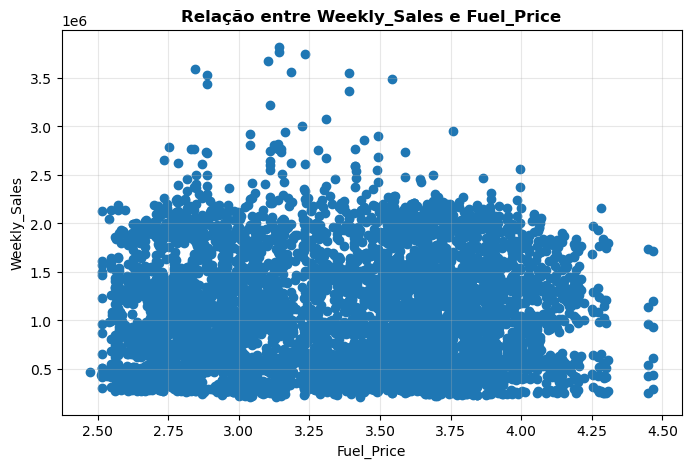

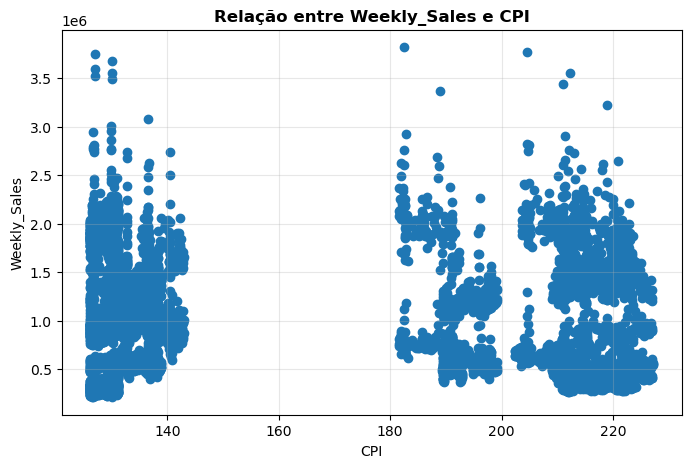

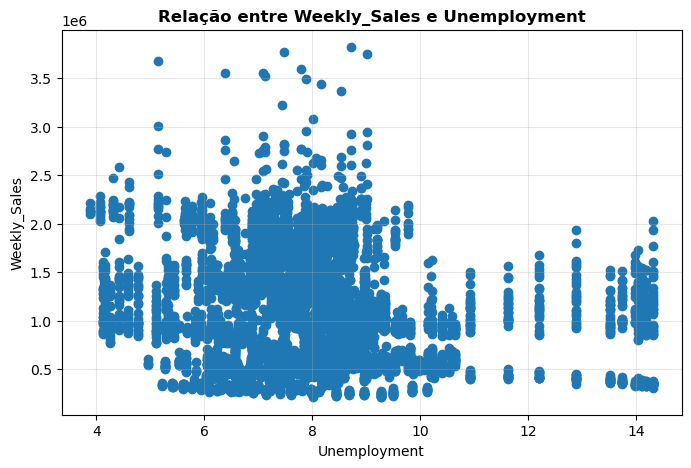

In [29]:
for eixo_x in X.columns:
    plot_scatter(eixo_x, 'Weekly_Sales', data=df)

**Conclusão: As variáveis não possuem uma tendência**

### Visualizando a relação das variáveis independentes com as variáveis dependente (linearizando os dados)

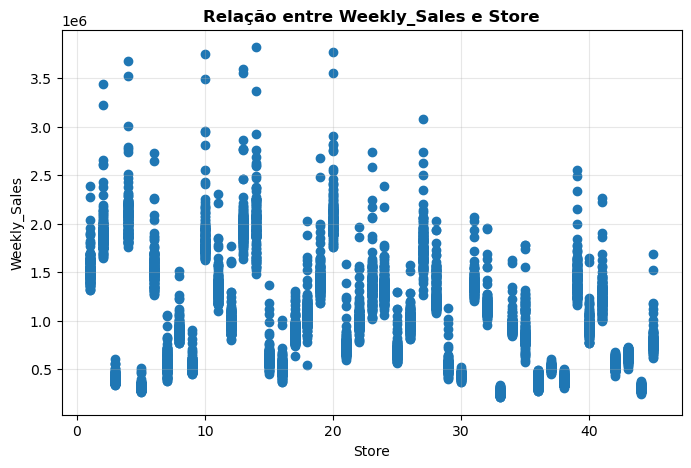

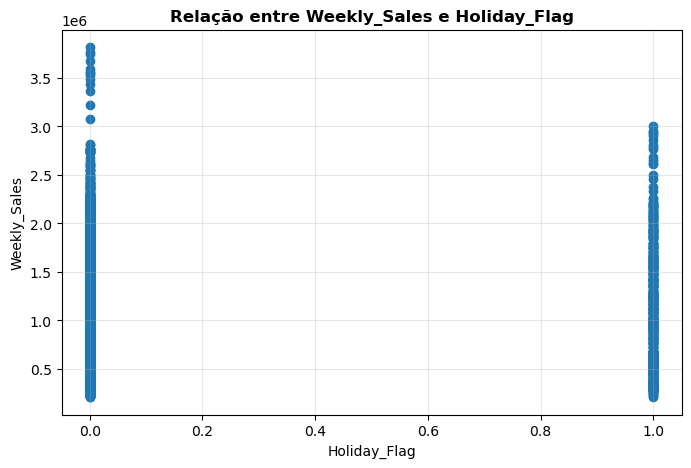

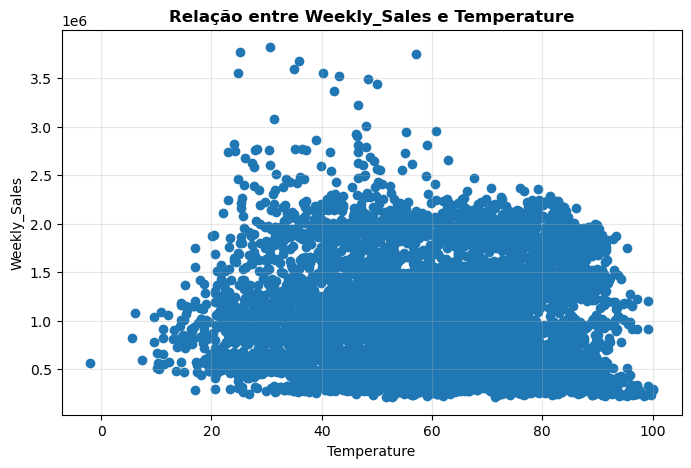

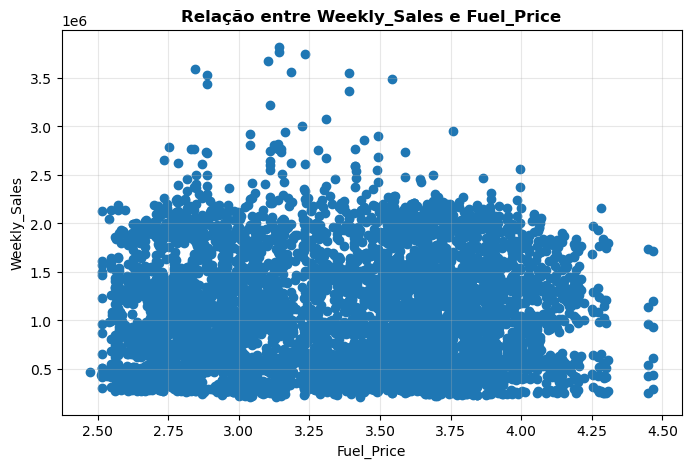

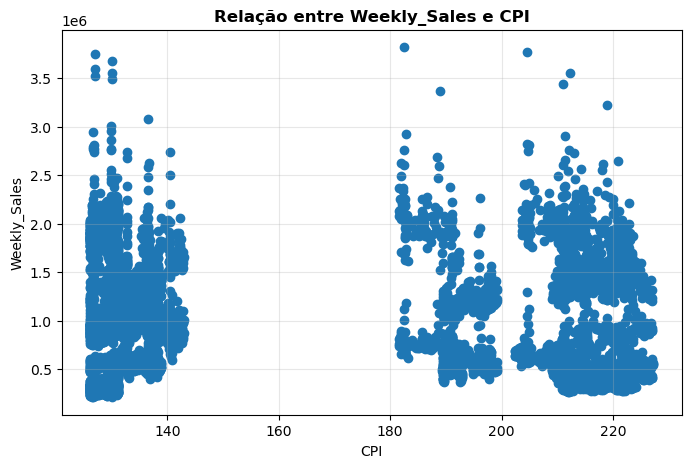

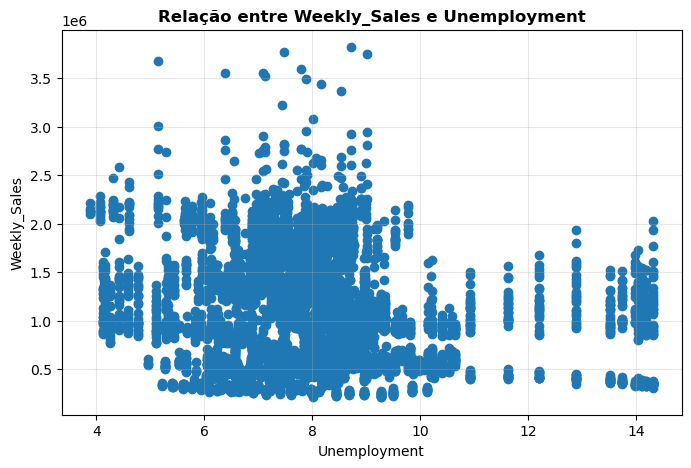

In [30]:
for eixo_x in X_linearizado.columns:
    plot_scatter(eixo_x, 'Weekly_Sales', data=df)

**Conclusão: As variáveis não possuem uma tendência**

### Por não possuírem o uma tendência linear, o ideal seria usar outro modelo de regressão. Porém, por motivos de treinamento, iremos usar o modelo de regressão linear multipla para praticar !

### Visualizando o mapa de correlação entre as variáveis

<AxesSubplot:>

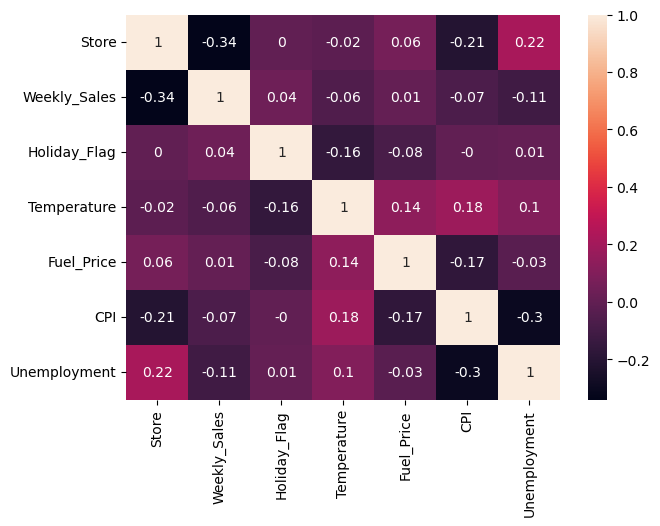

In [31]:
plt.figure(figsize = (7,5))
sns.heatmap(round(df[['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment']].corr(),2), annot = True)

**Conclusão: As variáveis não possuem correlação**

### Separando as variáveis em treino e teste

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

# Criando modelo preditivo

### Instânciando e treinando o modelo

In [33]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

LinearRegression()

### Retornando o intercepto do modelo

In [34]:
linear_model.intercept_

2012457.3721190721

### Retornando os parâmetros de inclinação

In [35]:
linear_model.coef_

array([-15434.94596459,  59562.30867042,  -1498.99894238,   9918.03828931,
        -2351.40112744, -18744.74832562])

### Previsão com os dados de treino e teste

In [36]:
y_pred_train = linear_model.predict(X_train)

y_pred_test = linear_model.predict(X_test)

### Criando uma função para calcular o rmse

In [37]:
def rmse(y_true, y_pred):
    "Calcula o RMSE."
    return round(sqrt(mean_squared_error(y_true, y_pred)), 2)

### Retornando o rmse

In [38]:
# Métrica nos dados de treino
rmse(y_train, y_pred_train)

525307.29

In [39]:
# Métrica nos dados de teste
rmse(y_test, y_pred_test)

517548.12

### Retornando o R2

In [40]:
# Métrica nos dados de treino
linear_model.score(X_train, y_train)

0.14186543573940524

In [41]:
# Métrica nos dados de teste
linear_model.score(X_test, y_test)

0.1393048945100035

### Exportando o modelo

In [43]:
nome_arquivo = 'regressão_linear.pkl'
joblib.dump(linear_model, nome_arquivo)

['regressão_linear.pkl']